# Машинное обучение в продакшене
# Первое ДЗ

## libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import time
import pickle
import gc

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('default')

## heart

In [3]:
path = os.path.join('..', 'data', 'raw', 'heart.csv')
heart = pd.read_csv(path)
heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
assert heart.isna().sum().sum() == 0

## eda

### target

In [6]:
target = heart.pop('target')

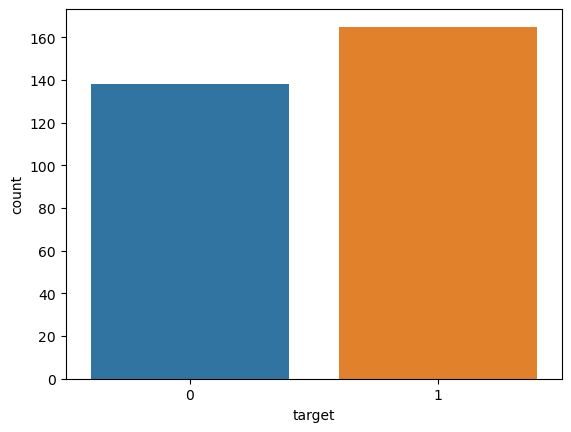

In [7]:
sns.countplot(x=target)
plt.show()

### columns

In [8]:
heart.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
dtype: int64

In [58]:
bin_cols = ['sex','fbs','exang',]
cat_cols = ['cp','restecg','slope','thal']
num_cols = ['age','trestbps','chol','thalach','oldpeak','ca']
assert set(bin_cols) | set(cat_cols) | set(num_cols) == set(heart.columns)

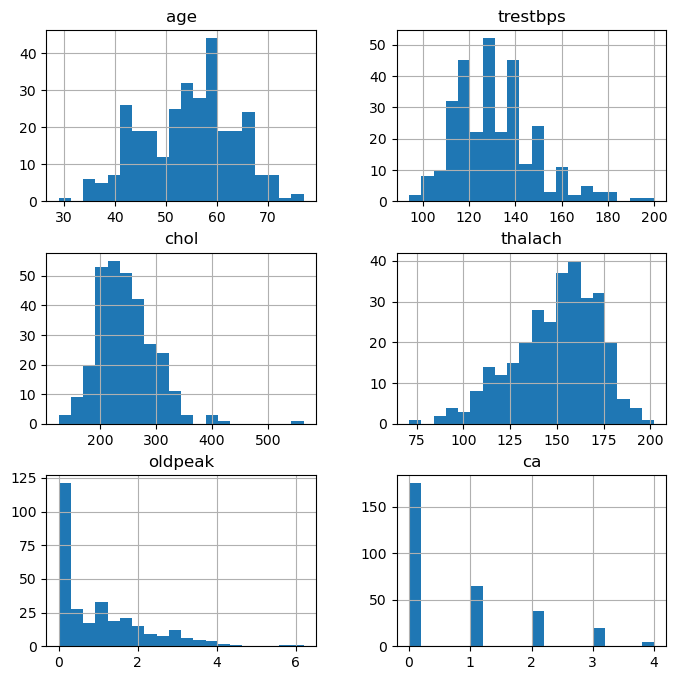

In [59]:
heart[num_cols].hist(bins=20, figsize=(8, 8));

In [60]:
def hist_box(series, suptitle=''): #, bins=50
    '''Строит гистограмму и ящик с усами'''
    fig, axes = plt.subplots(nrows=2, figsize=(6,4), sharex=True
        ,gridspec_kw={'height_ratios':[6,1]})
    if suptitle:
        fig.suptitle(suptitle, fontsize="x-large") #, fontsize=14
        fig.subplots_adjust(top=0.9)

    plt.sca(axes[0])
    sns.histplot(series) #, bins=bins
    plt.axvline(series.mean(), color='g', lw=1)
    plt.xlabel('')
    plt.grid(True, axis='y') 
    plt.box(False)    

    plt.sca(axes[1])
    sns.boxplot(x=series, ax=plt.gca())
    # plt.xlabel('Ошибка прогноза')
    plt.box(False)

    fig.tight_layout()
    plt.show()

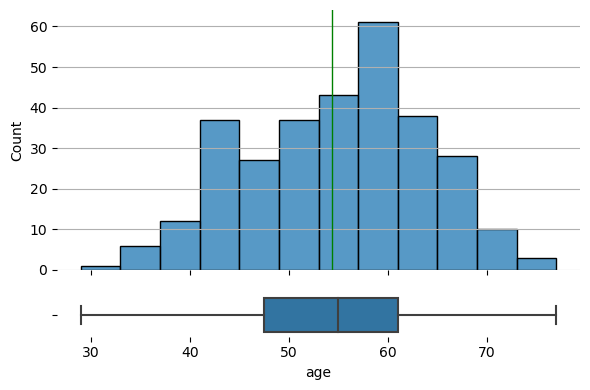

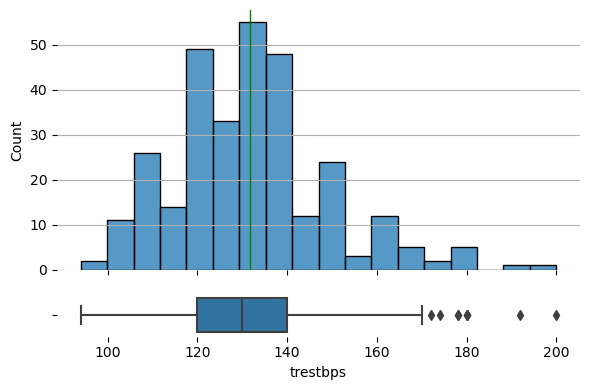

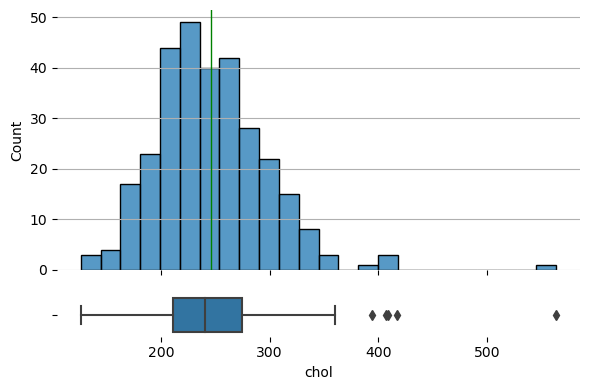

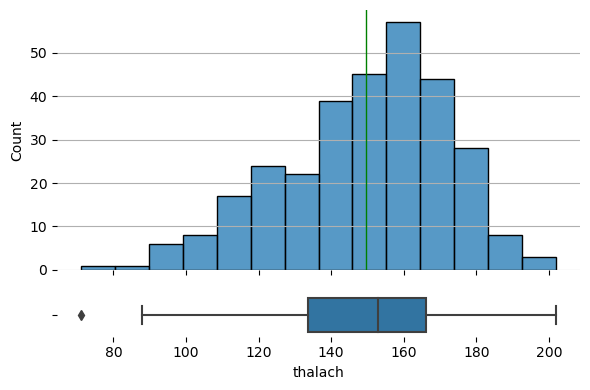

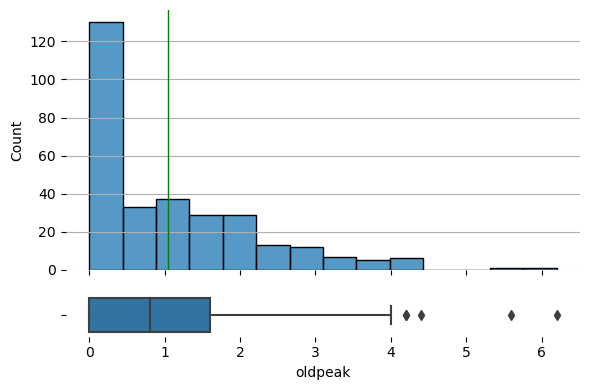

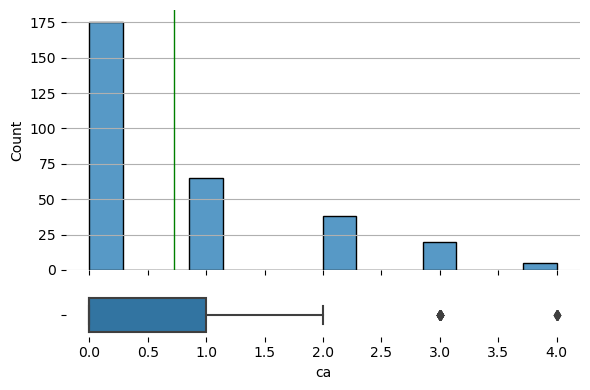

In [61]:
for col in num_cols:
    hist_box(heart[col])

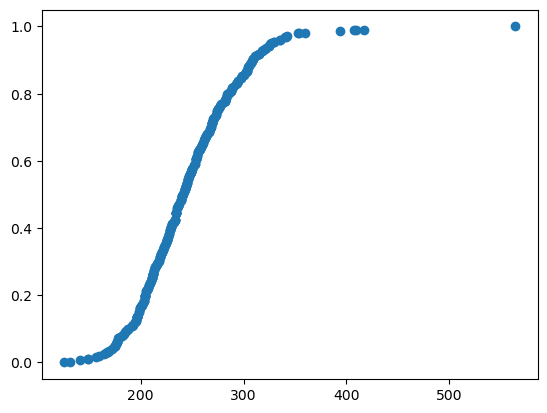

In [40]:
qt = QuantileTransformer(n_quantiles=100, )
chol_sc = qt.fit_transform(heart[['chol']])
plt.scatter(heart['chol'], chol_sc)

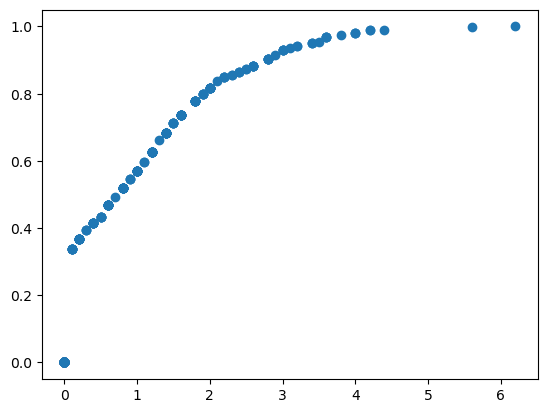

In [15]:
qt = QuantileTransformer(n_quantiles=100, )
chol_sc = qt.fit_transform(heart[['oldpeak']])
plt.scatter(heart['oldpeak'], chol_sc)

<AxesSubplot:ylabel='Count'>

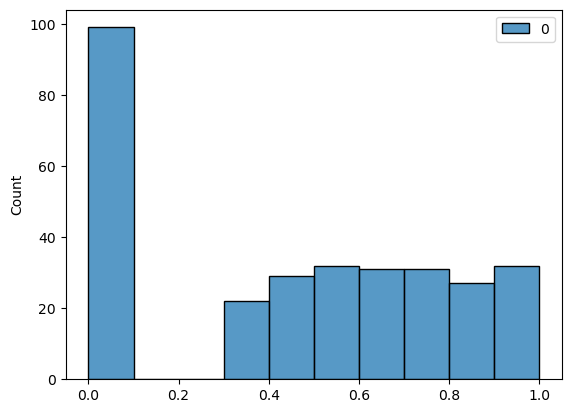

In [16]:
sns.histplot(chol_sc)

In [62]:
# RF (deep=10, ) - 0.87
# test_split = 0.2

## train_test

In [63]:
from sklearn.model_selection import train_test_split

In [85]:
heart_train, heart_test, target_train, target_test = train_test_split(
    heart, target, test_size=0.2, random_state=42
)
heart_train.shape, heart_test.shape, target_train.shape, target_test.shape

((242, 13), (61, 13), (242,), (61,))

## pipeline

In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer

In [87]:
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='if_binary'))
])

In [88]:
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

In [89]:
col_transformer = ColumnTransformer([
    ('categorical_pipeline', cat_pipe, bin_cols + cat_cols), 
    ('num_pipe', num_pipe, num_cols),
])

In [90]:
x_train = col_transformer.fit_transform(heart_train)
x_train.shape

(242, 23)

In [91]:
x_test = col_transformer.transform(heart_test)
x_test.shape

(61, 23)

## model

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score

In [93]:
model = RandomForestClassifier(max_depth=5)
model.fit(x_train, target_train)
model.score(x_train, target_train)

0.9380165289256198

In [94]:
y_pred = model.predict(x_test)
f1_score(y_pred, target_test)

0.875

In [95]:
confusion_matrix(y_pred, target_test)

array([[25,  4],
       [ 4, 28]])

## bottom

In [82]:
gc.collect()

15